In [49]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Data processing

In [72]:
# https://data.boston.gov/dataset/311-service-requests
raw = pd.read_csv('tmpkab7z67g.csv')
raw.shape

(1611147, 29)

In [73]:
raw.columns

Index(['case_enquiry_id', 'open_dt', 'target_dt', 'closed_dt', 'ontime',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submittedphoto', 'closedphoto',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'source'],
      dtype='object')

#### Drop columns that are not interesting.

In [74]:
raw.drop(['case_enquiry_id', 'target_dt', 'case_title', 'closure_reason', 'type', 'queue', 'department', 
          'submittedphoto', 'closedphoto', 'location', 'fire_district', 'pwd_district', 'police_district',
          'neighborhood_services_district', 'ward', 'precinct', 'location_street_name', 'location_zipcode', \
         'city_council_district', 'case_status'], 
         axis=1, inplace=True)

raw.neighborhood.replace({' ': np.nan}, inplace=True)
raw.dropna(axis=0, inplace=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444644 entries, 0 to 1611143
Data columns (total 9 columns):
open_dt         1444644 non-null object
closed_dt       1444644 non-null object
ontime          1444644 non-null object
subject         1444644 non-null object
reason          1444644 non-null object
neighborhood    1444644 non-null object
latitude        1444644 non-null float64
longitude       1444644 non-null float64
source          1444644 non-null object
dtypes: float64(2), object(7)
memory usage: 110.2+ MB


#### Deal with timestamp columns.
* Convert open and close date data to datetime dtype.
* Extract year and month for further analysis.
* Calculate processing time as duration in hours.

In [76]:
raw.open_dt = pd.to_datetime(raw.open_dt)
raw.closed_dt = pd.to_datetime(raw.closed_dt)

raw['duration'] = (raw.closed_dt - raw.open_dt)/np.timedelta64(1,'h')

raw['open_y'] = raw['open_dt'].dt.year
raw['open_m'] = raw['open_dt'].dt.month
raw['open_d'] = raw['open_dt'].dt.day
raw['open_day_of_week'] = raw['open_dt'].dt.dayofweek

In [77]:
raw = raw[raw.duration>=0]
raw = raw[(raw.open_y<=2018) & (raw.open_y>=2013) & (raw.ontime=='ONTIME')]

#### Merge 311 data with heterogenous boston weather data

In [78]:
# https://www.kaggle.com/jqpeng/boston-weather-data-jan-2013-apr-2018 
w = pd.read_csv('weather.csv')
new_df = pd.merge(raw, w, how='left', left_on=['open_y','open_m', 'open_d'], right_on = ['Year','Month', 'Day'])
new_df.drop(['Year', 'Month', 'Day', 'open_d', 'ontime'], axis=1, inplace=True)
new_df.shape

(936602, 14)

In [79]:
new_df.head()

,open_dt,closed_dt,subject,reason,neighborhood,latitude,longitude,source,duration,open_y,open_m,open_day_of_week,Avg Temp (F),Precip (in)
0,2013-02-01 19:46:12,2013-02-12 18:58:42,Mayor's 24 Hour Hotline,Notification,Dorchester,42.2883,-71.0588,Constituent Call,263.208333,2013,2,4,29,0.00
1,2013-04-12 13:33:07,2013-04-15 16:45:14,Mayor's 24 Hour Hotline,Notification,Dorchester,42.3179,-71.0676,Constituent Call,75.201944,2013,4,4,41,0.35
2,2013-01-01 14:16:13,2013-01-03 21:48:59,Public Works Department,Sanitation,Roxbury,42.3086,-71.0855,Self Service,55.546111,2013,1,1,29,0.00
3,2013-01-01 14:18:49,2013-01-04 21:47:44,Public Works Department,Sanitation,South End,42.3440,-71.0704,Self Service,79.481944,2013,1,1,29,0.00
4,2013-01-01 08:06:39,2013-01-10 13:40:56,Transportation - Traffic Division,Signs & Signals,Roxbury,42.3373,-71.0840,Constituent Call,221.571389,2013,1,1,29,0.00


# EDA

#### Request volume by year and month.

Text(0, 0.5, 'Request volume')

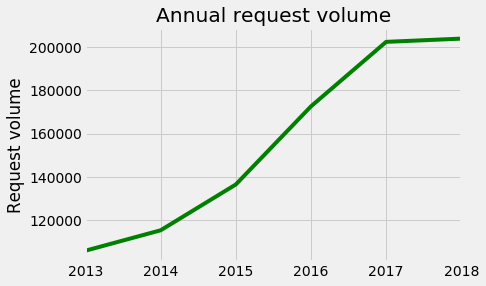

In [80]:
fig_y = new_df.groupby(['open_y']).size().plot(title = 'Annual request volume',
                                            style = 'green')
plt.xlabel('')
plt.ylabel('Request volume')

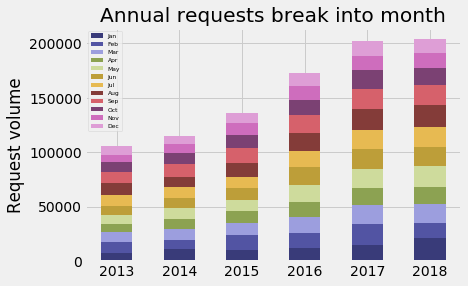

In [81]:
fig_y_m = new_df.groupby(['open_y', 'open_m']).size().unstack().plot(kind='bar', 
                                                        stacked=True, 
                                                        colormap='tab20b'
                                                        )
plt.title('Annual requests break into month')
plt.xlabel('')
plt.ylabel('Request volume')
plt.xticks(rotation=0)
plt.legend(labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           prop={'size': 6})

plt.show()

#### Request volume by subject.
* Classification hierarchy (SUBJECT > REASON > TYPE)
* There are 14 subjects in total.

In [82]:
sub = new_df.subject.value_counts()
print(sub)

Public Works Department              595829
Transportation - Traffic Division    178399
Inspectional Services                 55422
Parks & Recreation Department         54417
Mayor's 24 Hour Hotline               24295
Property Management                   17317
Boston Water & Sewer Commission        6164
Animal Control                         4599
Boston Police Department                112
Neighborhood Services                    36
Disability Department                     7
Consumer Affairs & Licensing              5
Name: subject, dtype: int64


#### Request volume by source.

In [83]:
source = new_df.source.value_counts()
print(source)

Constituent Call        381573
Citizens Connect App    291266
City Worker App         118972
Self Service             70338
Employee Generated       69783
Maximo Integration        3489
Twitter                   1181
Name: source, dtype: int64


#### Reasons under a specific subject.

In [84]:
new_df[new_df.subject=='Public Works Department'].groupby(['reason']).size().sort_values(ascending=False)

reason
Sanitation                           171069
Street Cleaning                      152989
Highway Maintenance                  117492
Code Enforcement                      73479
Street Lights                         37900
Recycling                             35972
Administrative & General Requests      6871
Bridge Maintenance                       57
dtype: int64

### Explore processing time.

Text(0, 0.5, 'Median processing time (hr)')

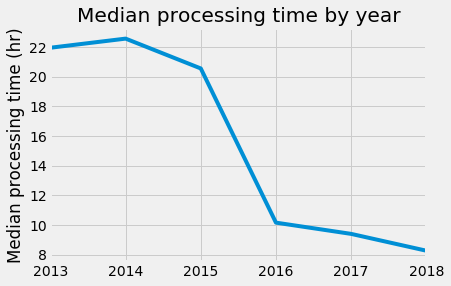

In [85]:
new_df.groupby('open_y')['duration'].median().plot()
plt.title('Median processing time by year')
plt.xlabel('')
plt.ylabel('Median processing time (hr)')

#### Median processing time by neighborhood.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text yticklabel objects>)

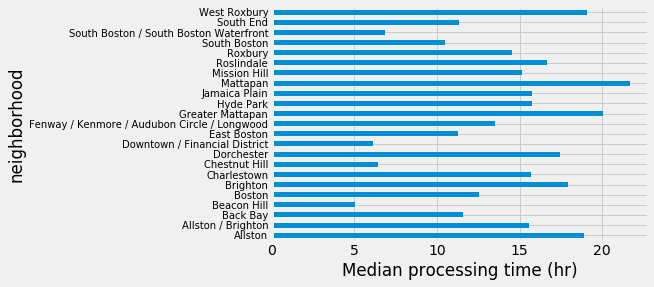

In [86]:
new_df.groupby('neighborhood')['duration'].median().plot(kind='barh')
plt.xlabel('Median processing time (hr)')
plt.yticks(fontsize=10)

#### Median processing time by subject.

Text(0.5, 0, 'Median processing time (hr)')

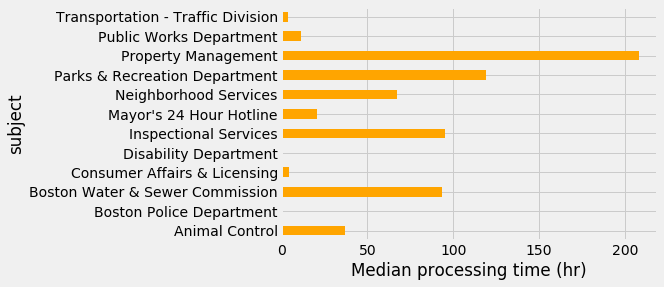

In [91]:
new_df[new_df['subject']!='CRM Application'].groupby('subject')['duration'].median().plot(kind='barh',color='orange')
plt.xlabel('Median processing time (hr)')

#### Median processing time by open month.

Text(0, 0.5, 'Request open month')

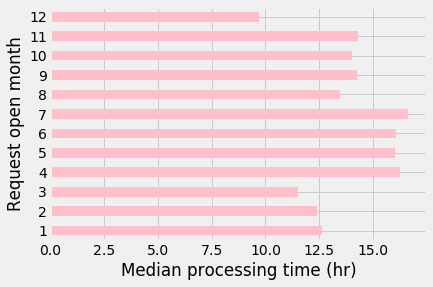

In [92]:
new_df.groupby('open_m')['duration'].median().plot(kind='barh',color='pink')
plt.xlabel('Median processing time (hr)')
plt.ylabel('Request open month')

#### Request volume by month.

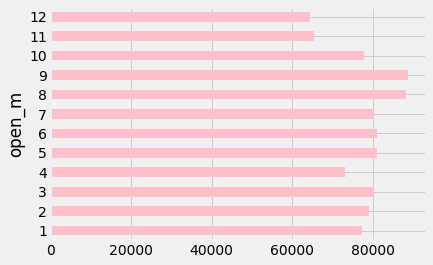

In [93]:
new_df.groupby('open_m').size().plot(kind='barh',color='pink')


#### Mean processing time by open day of week.

Text(0.5, 0, 'Median processing time (hr)')

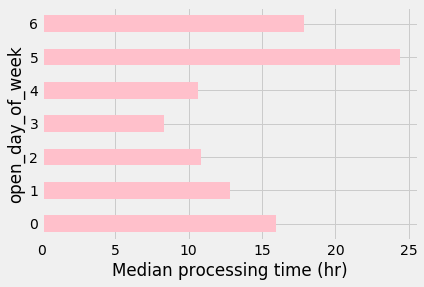

In [94]:
new_df.groupby('open_day_of_week')['duration'].median().plot(kind='barh', color='pink')
plt.xlabel('Median processing time (hr)')


#### Processing time and weather.

Text(0.5, 0, 'Month')

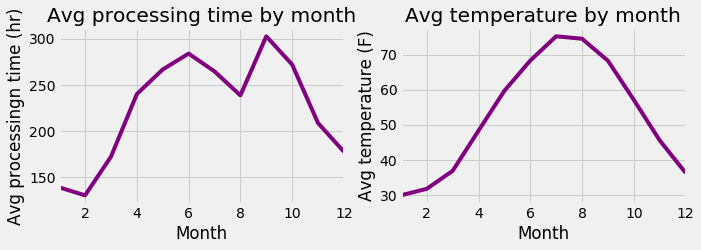

In [117]:
plt.figure(figsize=(10,3))

p1 = plt.subplot(121)
p1 = new_df.groupby('open_m')['duration'].mean().plot(color='purple')
plt.xlabel('Month')
plt.ylabel('Avg processingn time (hr)')
plt.title('Avg processing time by month')

p2 = plt.subplot(122)
p2 = new_df.groupby('open_m')['Avg Temp (F)'].mean().plot(color='purple')
plt.ylabel('Avg temperature (F)')
plt.title('Avg temperature by month')

plt.xlabel('Month')

In [120]:
new_df.corr()

,latitude,longitude,duration,open_y,open_m,open_day_of_week,Avg Temp (F),Precip (in)
latitude,1.000000,0.495453,-0.007349,0.154860,0.021437,0.058099,0.023846,-0.001467
longitude,0.495453,1.000000,-0.011953,0.116540,0.020875,0.029324,0.018628,0.005043
duration,-0.007349,-0.011953,1.000000,-0.064754,0.025293,-0.023169,0.040882,0.000086
open_y,0.154860,0.116540,-0.064754,1.000000,-0.017743,0.048609,0.031536,0.027659
open_m,0.021437,0.020875,0.025293,-0.017743,1.000000,-0.018955,0.376377,0.036148
open_day_of_week,0.058099,0.029324,-0.023169,0.048609,-0.018955,1.000000,-0.041020,-0.002178
Avg Temp (F),0.023846,0.018628,0.040882,0.031536,0.376377,-0.041020,1.000000,0.018727
Precip (in),-0.001467,0.005043,0.000086,0.027659,0.036148,-0.002178,0.018727,1.000000
